# Dots & Boxes

_by Apoorv Pandey_

## Introduction

This project is about making use of a Q-learning reinforcement algorithm to implement a game-playing agent which learns how to play a game of [3x3](https://www.wikihow.com/images/thumb/c/cb/Win-at-the-Dot-Game-Step-3.jpg/aid608874-v4-900px-Win-at-the-Dot-Game-Step-3.jpg) [Dots and Boxes](https://en.wikipedia.org/wiki/Dots_and_Boxes) optimally for both players.

## 3x3 Dots & Boxes

Dots & boxes is a 2-player game.

The starting state is an empty grid of dots (16 dots in case of a 3x3 size board). Both players take turns making a move; a move consists of adding either a horizontal or vertical line between two unjoined adjacent dots. If making a move completes a 1x1 box, then the player who made that move wins that particular box (essentially, gets a point); the player also retains their turn. The game ends when there are no more available moves left to make. The player with the most points number of points is the winner of the game.

In combinatorial game theory, dots & boxes is an impartial game and many positions can be analyzed using Sprague–Grundy theory. However, dots & boxes lacks the normal play convention of most impartial games (where the last player to move wins), which complicates the analysis considerably. **\[1\]**

### Representing the game

Determining how to store and represent the game is a bit tricky, since both the dots and their intermediate edges are valid to the game state. However, representing both dots and edges is not feasible since doing so requires either multiple lists or nested ones, both of which are not unviable to use as input parameters to the neural network.

One can, however, observe that the dots are constant for every state. Hence, a game state can be represented solely by its edges. All edges in the game are represented as a list (of length 24, since there are 24 edges in a 3x3 size game), with 0 denoting that an edge does not exist, and one denoting otherwise.

The edge ordering being considered is:

**&#183;**&nbsp;&nbsp;&nbsp; 0 &nbsp;&nbsp;&nbsp;**&#183;**&nbsp;&nbsp;&nbsp; 1 &nbsp;&nbsp;&nbsp;**&#183;**&nbsp;&nbsp;&nbsp; 2 &nbsp;&nbsp;&nbsp;**&#183;**  
12 &nbsp;&nbsp;&nbsp;&nbsp; 13 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 14 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 15  
**&#183;**&nbsp;&nbsp;&nbsp; 3 &nbsp;&nbsp;&nbsp;**&#183;**&nbsp;&nbsp;&nbsp; 4 &nbsp;&nbsp;&nbsp;**&#183;**&nbsp;&nbsp;&nbsp; 5 &nbsp;&nbsp;&nbsp;**&#183;**  
16 &nbsp;&nbsp;&nbsp;&nbsp; 17 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 18 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 19  
**&#183;**&nbsp;&nbsp;&nbsp; 6 &nbsp;&nbsp;&nbsp;**&#183;**&nbsp;&nbsp;&nbsp; 7 &nbsp;&nbsp;&nbsp;**&#183;**&nbsp;&nbsp;&nbsp; 8 &nbsp;&nbsp;&nbsp;**&#183;**  
20 &nbsp;&nbsp;&nbsp;&nbsp; 21 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 22 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 23  
**&#183;**&nbsp;&nbsp;&nbsp; 9 &nbsp;&nbsp;&nbsp;**&#183;**&nbsp;&nbsp; 10 &nbsp;&nbsp;**&#183;**&nbsp;&nbsp; 11 &nbsp;&nbsp;**&#183;**  

The index of a value in this list represents the corresponding edge, e.g. if edge 0 exists in a state, then index 0 in the list has value 1, and vice versa.

### Functions

The following functions are implemented for the dots & boxes game:
* `print_game(state)`: Prints the state of the game in a format which is easier to visualize.
* `valid_moves(state)`: Returns list of valid moves (moves possible under the aforementioned constraints) from `state`.
* `make_move(state, move)`: Returns new state after `move` has been applied to `state`.
* `box_created(state, boxes):`: Checks if a new box was created and returns an appropriate True/False value.
* `print_prediction(state)`: Prints the values which denote the best/worst steps that can be taken for a state.
* `plot_outcomes(outcomes, maxGames, nGames)`: Displays the average number of wins/losses/draws.

In [1]:
import numpy as np
import torch
import neuralnetwork as nn
import mlutils as ml

import random
from copy import copy

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def print_game(state):
    for i in range(4):
        for j in range(4):
            print('\u2022', end = '')
            print() if j == 3 else print('---', end = '') if state[((3*i)+j)] == 1 else print('   ', end = '')
        if i != 3:
            if(state[((4*i)+12)] == 1):
                print('|') if(state[((4*i)+13)] == 0 and state[((4*i)+14)] == 0 and state[((4*i)+15)] == 0) else print('|', end = '')
            if(state[((4*i)+13)] == 1):
                if(state[((4*i)+14)] == 0 and state[((4*i)+15)] == 0):
                    print('   |') if(state[((4*i)+12)] == 1) else print('    |')
                else:
                    print('   |', end = '') if(state[((4*i)+12)] == 1) else print('    |', end = '')
            if(state[((4*i)+14)] == 1):
                if(state[((4*i)+15)] == 0):
                    print('   |') if(state[((4*i)+13)] == 1) else print('       |') if(state[((4*i)+12)] == 1) else print('        |')
                else:
                    print('   |', end = '') if(state[((4*i)+13)] == 1) else print('       |', end = '') if(state[((4*i)+12)] == 1) else print('        |', end = '')
            if(state[((4*i)+15)] == 1):
                print('   |') if(state[((4*i)+14)] == 1) else print('       |') if(state[((4*i)+13)] == 1) else print('           |') if(state[((4*i)+12)] == 1) else print('            |')

            if(state[((4*i)+12)] == 0 and state[((4*i)+13)] == 0 and state[((4*i)+14)] == 0 and state[((4*i)+15)] == 0):
                print()

In [3]:
def valid_moves(state):
    return list(np.where(np.array(state) == 0)[0])

In [4]:
def make_move(state, move):
    newState = state.copy()
    newState[move] = 1
    return newState

In [5]:
def box_created(state, boxes):
    created = 0
    k = 0
    for i in range(9):
        if i != 0 and (i%3) == 0:
            k += 1
        if state[i] == 1 and state[(i+3)] == 1 and state[(i+12+k)] == 1 and state[(i+13+k)] == 1:
            if boxes[i] == 0:
                boxes[i] = 1
                created += 1
    return created, boxes

In [6]:
def print_prediction(state):
    for i in range(4):
        for j in range(4):
            print('    \u2022    ', end = '')
            print() if j == 3 else print(state[(3*i)+j], end = '')
        if i != 3:
            print(state[(4*i)+12], '    ', state[(4*i)+13], '    ', state[(4*i)+14], '    ', state[(4*i)+15])

In [7]:
def plot_outcomes(outcomes, max_games, n_games):
    if n_games == 0:
        return
    n_bins = 100
    n_per = int(max_games/n_bins)
    outcome_rows = outcomes.reshape(-1, n_per)
    outcome_rows = outcome_rows[:int(n_games/float(n_per))+1, :]
    avgs = np.mean(outcome_rows, axis = 1)
    xs = np.linspace(n_per, n_games, len(avgs))
    plt.figure(figsize = (15, 10))
    plt.plot(xs, np.sum(outcome_rows == 1, axis = 1), 'g-', label='P1 wins')
    plt.plot(xs, np.sum(outcome_rows == -1, axis = 1), 'r-', label='P2 wins')
    plt.plot(xs, np.sum(outcome_rows == 0, axis = 1), 'b-', label='Draws')
    plt.legend(loc = "center")
    plt.ylabel('Number of Games\nin Bins of {:d}'.format(n_per))

### Testing

In [8]:
start_state = [0]*24

In [9]:
print_game(start_state)

•   •   •   •

•   •   •   •

•   •   •   •

•   •   •   •


The initial state of the game is only dots and no edges.

In [10]:
valid_moves(start_state)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23]

Since there are no edges yet, all the edges are valid moves for the initial state.

In [11]:
make_move(start_state, 1)

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

The function correctly modifies the state of the game.

In [12]:
print_game(make_move(start_state, 1))

•   •---•   •

•   •   •   •

•   •   •   •

•   •   •   •


Edge 1 (in correspondence with the game representation figure) is now present, while all other edges are absent.

In [13]:
example_state = make_move(start_state, 3)
print(example_state)
print()
print_game(make_move(start_state, 3))

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

•   •   •   •

•---•   •   •

•   •   •   •

•   •   •   •


Similarly, setting the value of edge 3 (in correspondence with the game representation figure) results in the above state.

In [14]:
print('Random state')
random_state = make_move(make_move(make_move(make_move(make_move([0]*24, 0), 3), 12), 13), 1)
print_game(random_state)
print()
print()

boxes = [1] + [0]*8

print('Make move at edge 4')
boxes_created_state_1 = make_move(random_state, 4)
print_game(boxes_created_state_1)
created, boxes = box_created(boxes_created_state_1, boxes)
print()
print('Boxes created:', created)
print()
print('Current boxes:', boxes)
print()
print()

print('Make move at edge 14')
box_created_state_2 = make_move(boxes_created_state_1, 14)
print_game(box_created_state_2)
created, boxes = box_created(box_created_state_2, boxes)
print()
print('Boxes created:', created)
print()
print('Current boxes:', boxes)

Random state
•---•---•   •
|   |
•---•   •   •

•   •   •   •

•   •   •   •


Make move at edge 4
•---•---•   •
|   |
•---•---•   •

•   •   •   •

•   •   •   •

Boxes created: 0

Current boxes: [1, 0, 0, 0, 0, 0, 0, 0, 0]


Make move at edge 14
•---•---•   •
|   |   |
•---•---•   •

•   •   •   •

•   •   •   •

Boxes created: 1

Current boxes: [1, 1, 0, 0, 0, 0, 0, 0, 0]


For the random state, when a move is made at edge 4, the function `box_created` correctly returns the value False, since no box was created by making that move. On making a move at edge 14, the function returns the value True, and the boxes list is modified accordingly.

## Q Function

The Q function is implemented using a neural network.

Basic flow of the training process is:
* For number of batches, repeat the following:
    * Initialize an empty sample list.
    * Repeat for number of repetitions per batch:
        * Initialize the starting state.
        * Play the game till completion (using function `epsilon_greedy` to choose a move).
            * When game is over, determine the appropriate reinforcement and add it to samples.
    * Extract the state + move (25 values) from each sub-list in state as weights, and the reinforcement value and `Qnext` value (values 26 and 27) from each state, whose sum serves as the target.
    * Train the neural network `Qnet` using these data points.

### Functions

The following functions are implemented for training the Q network:
* `tensor(np_array)`: Returns the tensor representation of a numpy array; sends tensor to CUDA cores if available, else keeps it on the CPU.
* `epsilon_greedy(Qnet, state, epsilon, valid_moves_F, turn)`: Returns the next move to be taken by the algorithm; allows for either a random move or a greedy move.
* `train_Qnet(n_batches, n_reps_per_batch, network, n_iterations, learning_rate, epsilon, epsilon_decay_factor, valid_moves_F, make_move_F, boxes_created_F, relu, use_SGD)`: This function trains the neural network which will serve as the Q function; it returns a trained neural network along with the outcomes and samples.
* `draw_Qnet(Qnet)`: Draws the weights in each layer of Qnet; how intermediate layer weights combine to produce weights for the next layer and so on.

In [15]:
cuda_available = torch.cuda.is_available()

In [16]:
def tensor(np_array):
    return torch.from_numpy(np_array.astype('double')).cuda() if cuda_available else torch.from_numpy(np_array.astype('double'))

In [17]:
def epsilon_greedy(Qnet, state, epsilon, valid_moves_F, turn):
    moves = valid_moves_F(state)
    if np.random.uniform() < epsilon: # Random move
        move = moves[random.sample(range(len(moves)), 1)[0]]
        Q = Qnet.use_pytorch(tensor(np.array(state + [move]))) if Qnet.Xmeans is not None else 0
    else: # Greedy move
        Qs = []
        for m in moves:
            Qs.append(Qnet.use_pytorch(tensor(np.array(state + [m]))) if Qnet.Xmeans is not None else 0)
        move = moves[np.argmax(Qs)] if turn else moves[np.argmin(Qs)]
        Q = np.max(Qs) if turn else np.min(Qs)
    return move, Q

In [18]:
def train_Qnet(n_batches, n_reps_per_batch, network, n_iterations, learning_rate,
               epsilon, epsilon_decay_factor, valid_moves_F, make_move_F, boxes_created_F, relu=False, use_SGD=False):
    
    # use CUDA cores if available, else use CPU
    Qnet = nn.PyTorchNN(25, network, 1, relu).to(torch.device('cuda' if cuda_available else 'cpu')).double()
    repk = -1
    outcomes = np.zeros(n_batches*n_reps_per_batch)
    
    for batch in range(n_batches):
        if batch > 0:
            epsilon *= epsilon_decay_factor
            epsilon = max(0.01, epsilon) # Minimum learning rate is 0.01
        samples = []
        
        for reps in range(n_reps_per_batch):
            repk += 1
            
            # Initialize game
            state = [0]*24
            boxes = [0]*9
            score = [0]*2
            done = False
            
            # Start game; player 1's turn initially
            turn = True
            move, _ = epsilon_greedy(Qnet, state, epsilon, valid_moves_F, turn)
            
            # Continue to play the game
            while not done:
                r = 0
                state_next = make_move_F(state, move)
                created, boxes = boxes_created_F(state_next, boxes) # Check how many boxes are created after making a move
                
                if created > 0: # If a box is created, update score of the player who made the move
                    if turn:
                        score[0] += created
                    else:
                        score[1] += created
                else: # Else give turn to the other player
                    turn = not turn
                
                if 0 not in state_next: # If there are no more edges remaining, the game is over
                    done = True # Set termination flag
                    Qnext = 0 # Determine the reinforcement
                    r = 1 if score[0] > score[1] else -1
                    outcomes[repk] = r
                    #move_next = -1
                else: # Else, determine next move and add current sample with reinforcement 0
                    move_next, Qnext = epsilon_greedy(Qnet, state_next, epsilon, valid_moves_F, turn)
                
                samples.append([*state, move, r, Qnext]) # Collect turn results as a sample
                state = state_next
                move = move_next
        
        samples = np.array(samples) # Samples contains the training inputs and the targets
        X = tensor(samples[:, :25]) # Training inputs to the neural network
        T = tensor(samples[:, 25:26]+samples[:, 26:27]) # Target values for the neural network
        Qnet, _ = Qnet.train_pytorch(X, T, learning_rate, n_iterations, use_SGD) # Training the neural network
    
    print('DONE')
    return Qnet, outcomes, samples

In [19]:
def draw_Qnet(Qnet):
    W = []
    for i in list(Qnet.parameters()):
        try:
            if i.detach().numpy().shape[1] > 0:
                W.append(i.detach().numpy().T)
        except:
            pass
    plt.figure(figsize=(12, 12))
    ml.draw(W)

## Training

Training models for different parameters, varying the neural network structure, the number of batches and the randomness likeliness.

Training 4 models for each set of parameters:
1. Adam optimizer and TanH activation function
2. Adam optimizer and ReLU activation function
3. SGD optimizer and TanH activation function
4. SGD optimizer and ReLU activation function

### Parameter values \#1

In [20]:
n_batches = 20
n_reps_per_batch = 1000
n_iterations = 50
network = [5]
learning_rate = 0.01
epsilon = 1
epsilon_decay_factor = 0.98

#### Adam, TanH

In [21]:
Qnet_1_Adam_TanH, outcomes_1_Adam_TanH, samples_1_Adam_TanH = train_Qnet(n_batches, n_reps_per_batch, network,
                                                                         n_iterations, learning_rate, epsilon,
                                                                         epsilon_decay_factor, valid_moves,
                                                                         make_move, box_created)

DONE


In [22]:
start_state = [0]*24
Q_1s_Adam_TanH = [Qnet_1_Adam_TanH.use_pytorch(tensor(np.array(start_state + [m]))) for m in range(24)]
print_prediction(Q_1s_Adam_TanH)

    •    [0.00854575]    •    [0.00730346]    •    [0.00606116]    •    
[-0.00636182]      [-0.00760412]      [-0.00884641]      [-0.01008871]
    •    [0.00481886]    •    [0.00357656]    •    [0.00233427]    •    
[-0.01133101]      [-0.01257331]      [-0.0138156]      [-0.0150579]
    •    [0.00109197]    •    [-0.00015033]    •    [-0.00139263]    •    
[-0.0163002]      [-0.0175425]      [-0.01878479]      [-0.02002709]
    •    [-0.00263493]    •    [-0.00387722]    •    [-0.00511952]    •    


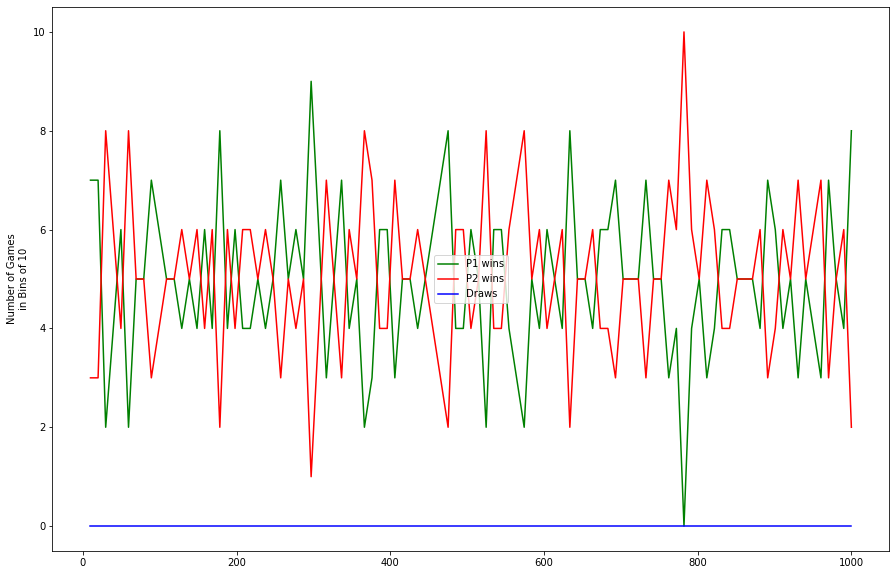

In [23]:
plot_outcomes(outcomes_1_Adam_TanH, 1000, 1000)

55.651899738581854 0.009755070128173848 369.82248520710056


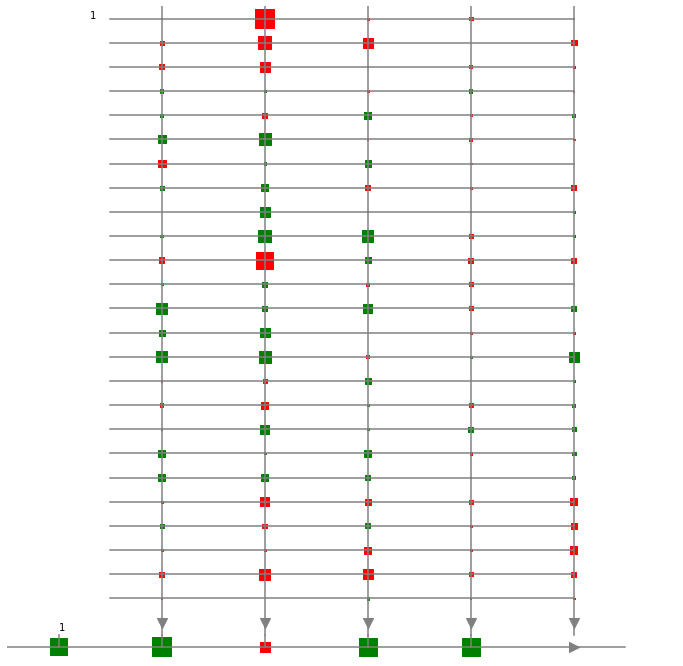

In [24]:
draw_Qnet(Qnet_1_Adam_TanH)

#### Adam, ReLU

In [25]:
Qnet_1_Adam_ReLU, outcomes_1_Adam_ReLU, samples_1_Adam_ReLU = train_Qnet(n_batches, n_reps_per_batch, network,
                                                                         n_iterations, learning_rate, epsilon,
                                                                         epsilon_decay_factor, valid_moves,
                                                                         make_move, box_created, relu=True)

DONE


In [26]:
start_state = [0]*24
Q_1s_Adam_ReLU = [Qnet_1_Adam_ReLU.use_pytorch(tensor(np.array(start_state + [m]))) for m in range(24)]
print_prediction(Q_1s_Adam_ReLU)

    •    [0.05270301]    •    [0.05407353]    •    [0.05544406]    •    
[0.06914928]      [0.0705198]      [0.07189033]      [0.07326085]
    •    [0.05681458]    •    [0.0581851]    •    [0.05955562]    •    
[0.07463137]      [0.07600189]      [0.07737242]      [0.07874294]
    •    [0.06092615]    •    [0.06229667]    •    [0.06366719]    •    
[0.08011346]      [0.08148398]      [0.08285451]      [0.08422503]
    •    [0.06503771]    •    [0.06640824]    •    [0.06777876]    •    


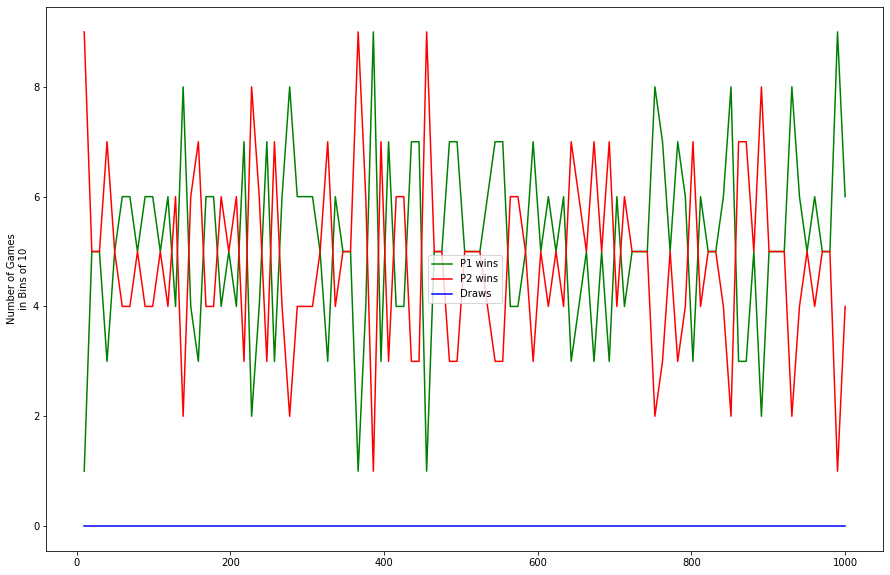

In [27]:
plot_outcomes(outcomes_1_Adam_ReLU, 1000, 1000)

62.06306450556829 0.015836653062437867 369.82248520710056


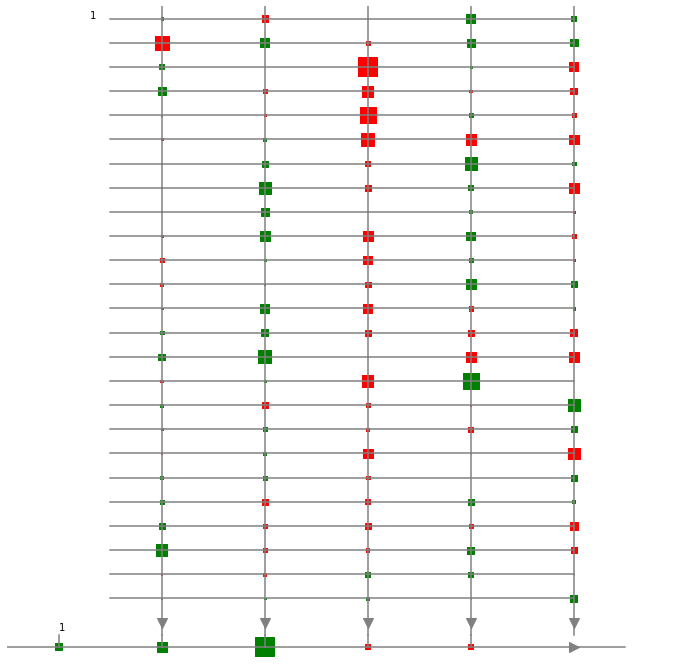

In [28]:
draw_Qnet(Qnet_1_Adam_ReLU)

#### SGD, TanH

In [29]:
Qnet_1_SGD_TanH, outcomes_1_SGD_TanH, samples_1_SGD_TanH = train_Qnet(n_batches, n_reps_per_batch, network,
                                                                         n_iterations, learning_rate, epsilon,
                                                                         epsilon_decay_factor, valid_moves,
                                                                         make_move, box_created, use_SGD=True)

DONE


In [30]:
start_state = [0]*24
Q_1s_SGD_TanH = [Qnet_1_SGD_TanH.use_pytorch(tensor(np.array(start_state + [m]))) for m in range(24)]
print_prediction(Q_1s_SGD_TanH)

    •    [-0.01080532]    •    [-0.01050695]    •    [-0.01020857]    •    
[-0.00722485]      [-0.00692648]      [-0.0066281]      [-0.00632973]
    •    [-0.0099102]    •    [-0.00961183]    •    [-0.00931346]    •    
[-0.00603136]      [-0.00573299]      [-0.00543461]      [-0.00513624]
    •    [-0.00901508]    •    [-0.00871671]    •    [-0.00841834]    •    
[-0.00483787]      [-0.0045395]      [-0.00424112]      [-0.00394275]
    •    [-0.00811997]    •    [-0.00782159]    •    [-0.00752322]    •    


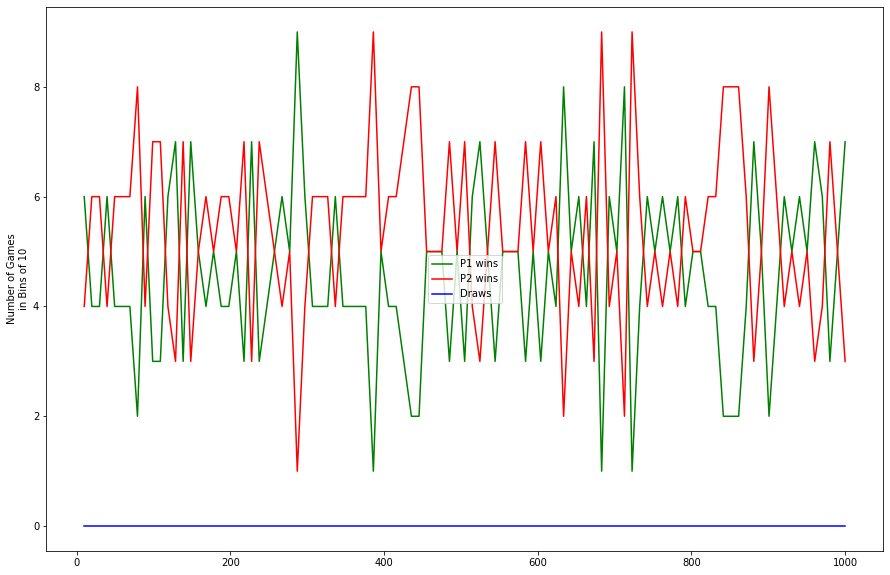

In [31]:
plot_outcomes(outcomes_1_SGD_TanH, 1000, 1000)

98.0977686075044 0.0002507293704438691 369.82248520710056


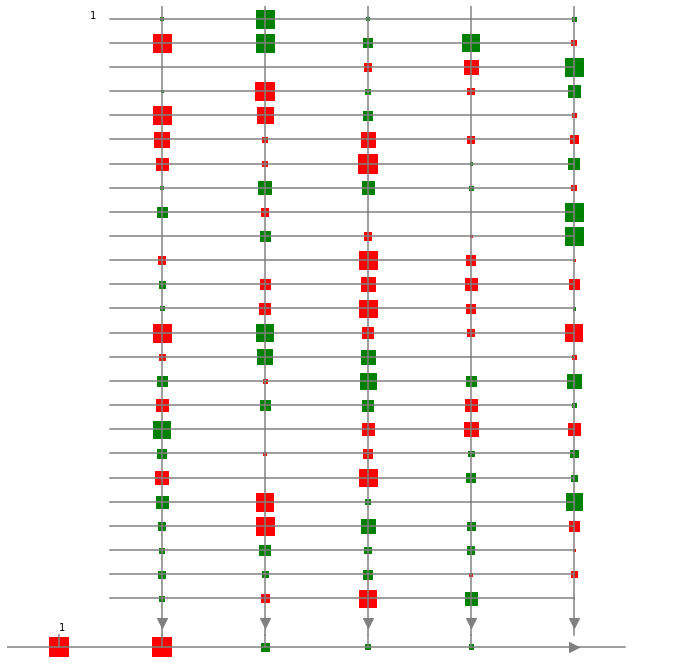

In [32]:
draw_Qnet(Qnet_1_SGD_TanH)

#### SGD, ReLU

In [33]:
Qnet_1_SGD_ReLU, outcomes_1_SGD_ReLU, samples_1_SGD_ReLU = train_Qnet(n_batches, n_reps_per_batch, network,
                                                                         n_iterations, learning_rate, epsilon,
                                                                         epsilon_decay_factor, valid_moves,
                                                                         make_move, box_created, relu=True, use_SGD=True)

DONE


In [34]:
start_state = [0]*24
Q_1s_SGD_ReLU = [Qnet_1_SGD_ReLU.use_pytorch(tensor(np.array(start_state + [m]))) for m in range(24)]
print_prediction(Q_1s_SGD_ReLU)

    •    [0.09776852]    •    [0.09836433]    •    [0.09896014]    •    
[0.10491829]      [0.1055141]      [0.10610992]      [0.10670573]
    •    [0.09955596]    •    [0.10015177]    •    [0.10074759]    •    
[0.10730154]      [0.10789736]      [0.10849317]      [0.10908899]
    •    [0.1013434]    •    [0.10193922]    •    [0.10253503]    •    
[0.1096848]      [0.11028061]      [0.11087643]      [0.11147224]
    •    [0.10313084]    •    [0.10372666]    •    [0.10432247]    •    


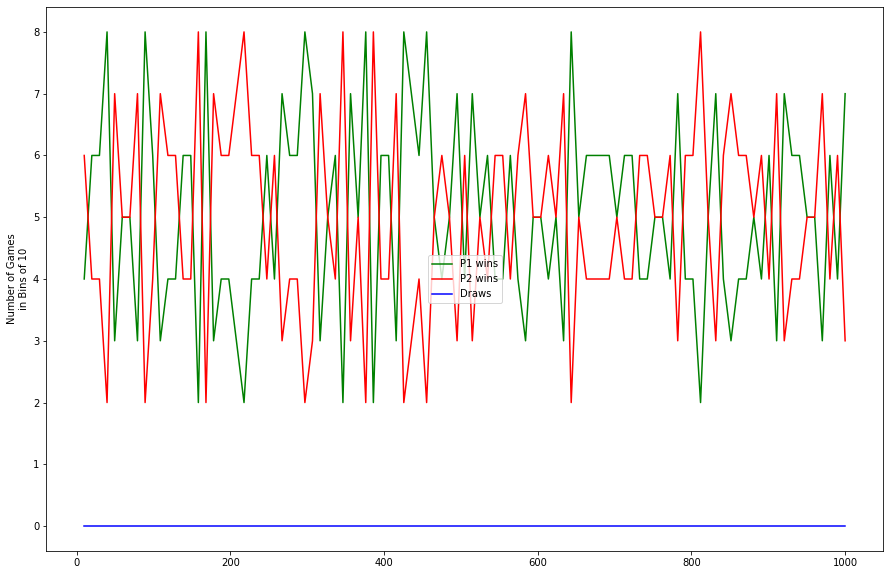

In [35]:
plot_outcomes(outcomes_1_SGD_ReLU, 1000, 1000)

96.3690905575538 0.07945566458615033 369.82248520710056


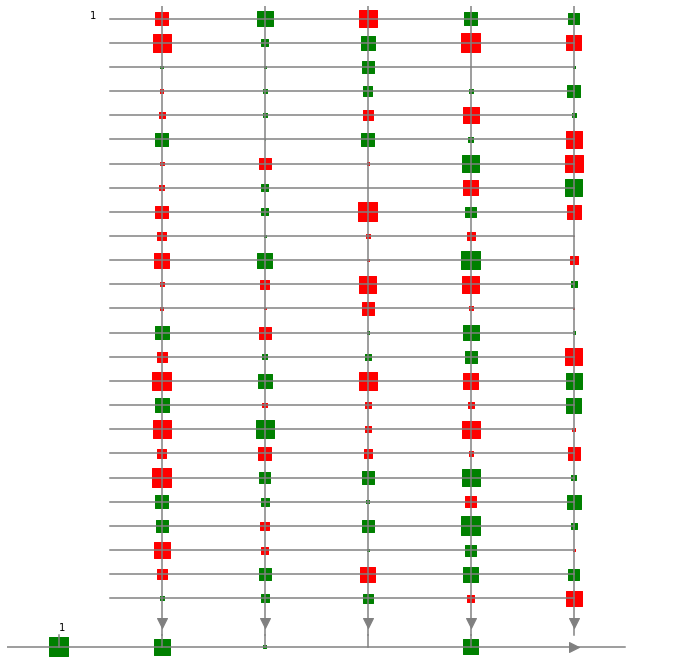

In [36]:
draw_Qnet(Qnet_1_SGD_ReLU)

### Parameter values \#2

In [37]:
n_batches = 50
n_reps_per_batch = 1000
n_iterations = 100
network = [10, 10]
learning_rate = 0.005
epsilon = 1
epsilon_decay_factor = 0.95

#### Adam, TanH

In [38]:
Qnet_2_Adam_TanH, outcomes_2_Adam_TanH, samples_2_Adam_TanH = train_Qnet(n_batches, n_reps_per_batch, network,
                                                                         n_iterations, learning_rate, epsilon,
                                                                         epsilon_decay_factor, valid_moves,
                                                                         make_move, box_created)

DONE


In [39]:
start_state = [0]*24
Q_2s_Adam_TanH = [Qnet_2_Adam_TanH.use_pytorch(tensor(np.array(start_state + [m]))) for m in range(24)]
print_prediction(Q_2s_Adam_TanH)

    •    [0.03324747]    •    [0.03536259]    •    [0.04721388]    •    
[0.0735496]      [0.07494016]      [0.07592395]      [0.07661374]
    •    [0.04966369]    •    [0.04070286]    •    [0.03997811]    •    
[0.07709322]      [0.07742352]      [0.07764868]      [0.07780019]
    •    [0.04661521]    •    [0.05408693]    •    [0.06037242]    •    
[0.07790039]      [0.07796503]      [0.07800517]      [0.07802856]
    •    [0.06525295]    •    [0.06891429]    •    [0.0716039]    •    


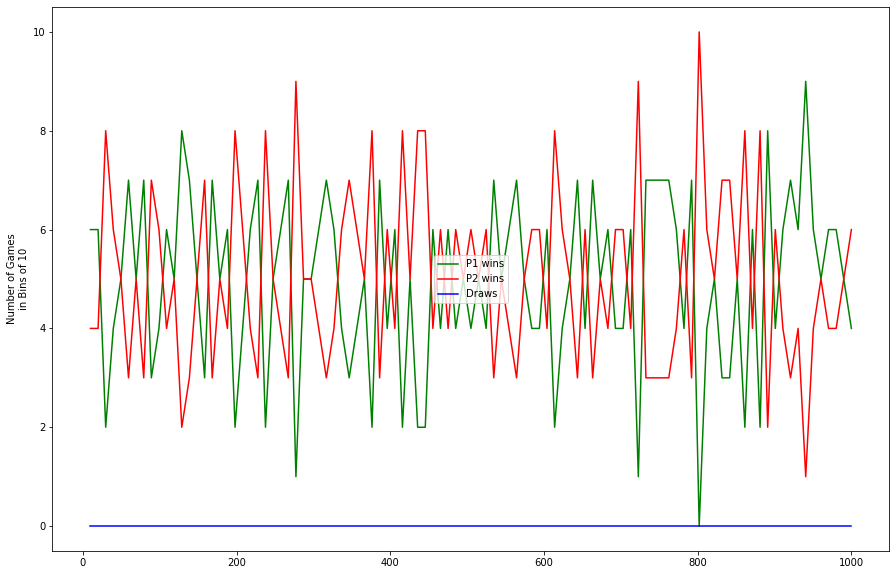

In [40]:
plot_outcomes(outcomes_2_Adam_TanH, 1000, 1000)

4.42702045184059 0.0005102451164631081 123.45679012345678
19.45559224192888 1.1090568393853624 123.45679012345678


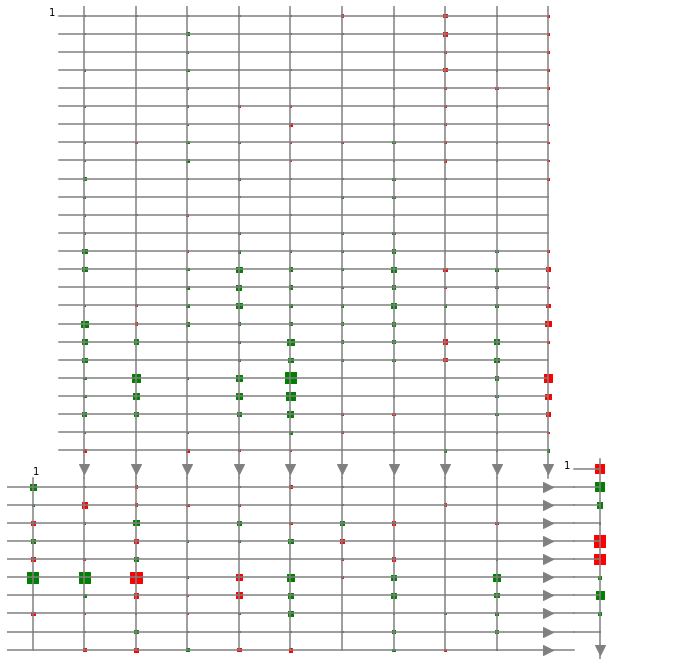

In [41]:
draw_Qnet(Qnet_2_Adam_TanH)

#### Adam, ReLU

In [42]:
Qnet_2_Adam_ReLU, outcomes_2_Adam_ReLU, samples_2_Adam_ReLU = train_Qnet(n_batches, n_reps_per_batch, network,
                                                                         n_iterations, learning_rate, epsilon,
                                                                         epsilon_decay_factor, valid_moves,
                                                                         make_move, box_created, relu=True)

DONE


In [43]:
start_state = [0]*24
Q_2s_Adam_ReLU = [Qnet_2_Adam_ReLU.use_pytorch(tensor(np.array(start_state + [m]))) for m in range(24)]
print_prediction(Q_2s_Adam_ReLU)

    •    [0.11228979]    •    [0.11228979]    •    [0.11228979]    •    
[0.11228979]      [0.11228979]      [0.11228979]      [0.11228979]
    •    [0.11228979]    •    [0.11228979]    •    [0.11228979]    •    
[0.11228979]      [0.11228979]      [0.11228979]      [0.11228979]
    •    [0.11228979]    •    [0.11228979]    •    [0.11228979]    •    
[0.11228979]      [0.11228979]      [0.11228979]      [0.11228979]
    •    [0.11228979]    •    [0.11228979]    •    [0.11228979]    •    


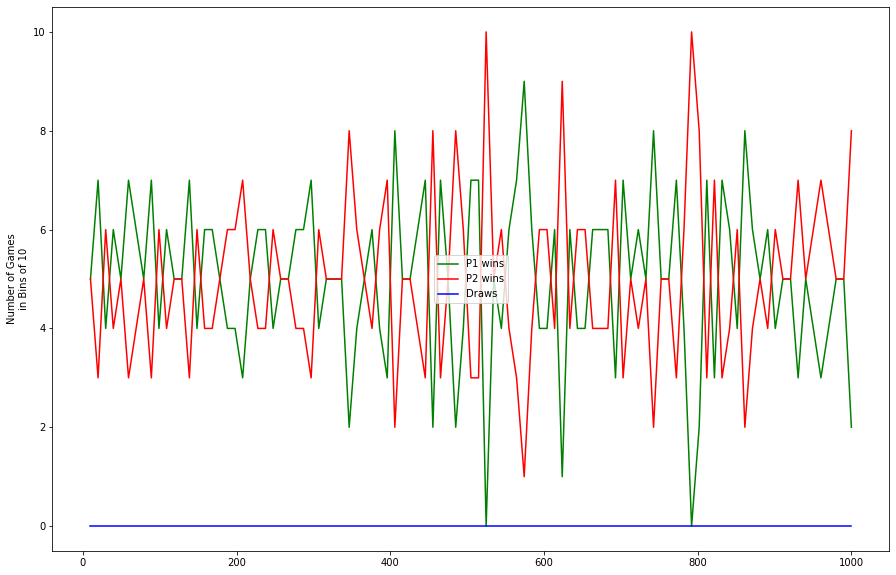

In [44]:
plot_outcomes(outcomes_2_Adam_ReLU, 1000, 1000)

9.471695116679902 7.348368646702312e-05 123.45679012345678
3.869811438735534 0.0003315668905690618 123.45679012345678


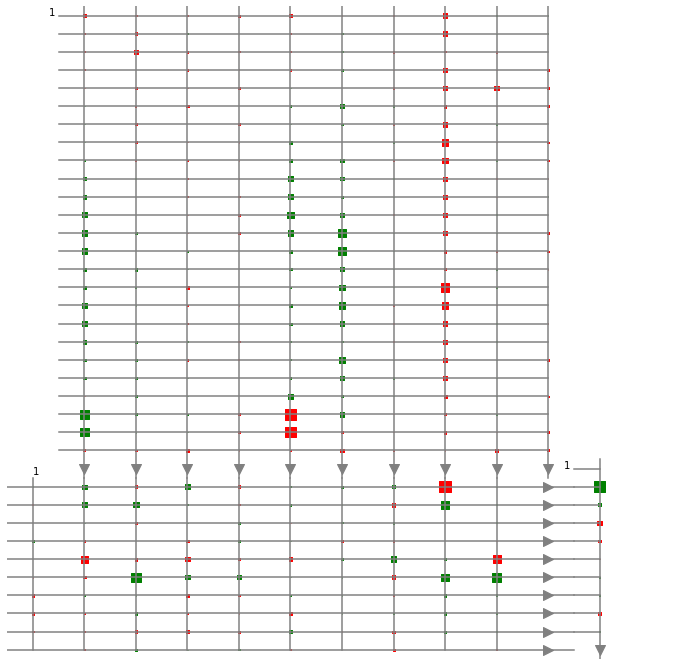

In [45]:
draw_Qnet(Qnet_2_Adam_ReLU)

#### SGD, TanH

In [46]:
Qnet_2_SGD_TanH, outcomes_2_SGD_TanH, samples_2_SGD_TanH = train_Qnet(n_batches, n_reps_per_batch, network,
                                                                         n_iterations, learning_rate, epsilon,
                                                                         epsilon_decay_factor, valid_moves,
                                                                         make_move, box_created, use_SGD=True)

DONE


In [47]:
start_state = [0]*24
Q_2s_SGD_TanH = [Qnet_2_SGD_TanH.use_pytorch(tensor(np.array(start_state + [m]))) for m in range(24)]
print_prediction(Q_2s_SGD_TanH)

    •    [-0.09159716]    •    [-0.0918758]    •    [-0.09255482]    •    
[-0.09975088]      [-0.10015586]      [-0.10060156]      [-0.10109676]
    •    [-0.09352695]    •    [-0.09462338]    •    [-0.09569287]    •    
[-0.10164339]      [-0.10223843]      [-0.1028755]      [-0.10354625]
    •    [-0.0966394]    •    [-0.09742477]    •    [-0.09805455]    •    
[-0.10424142]      [-0.10495162]      [-0.10566779]      [-0.10638157]
    •    [-0.09856034]    •    [-0.0989845]    •    [-0.09936936]    •    


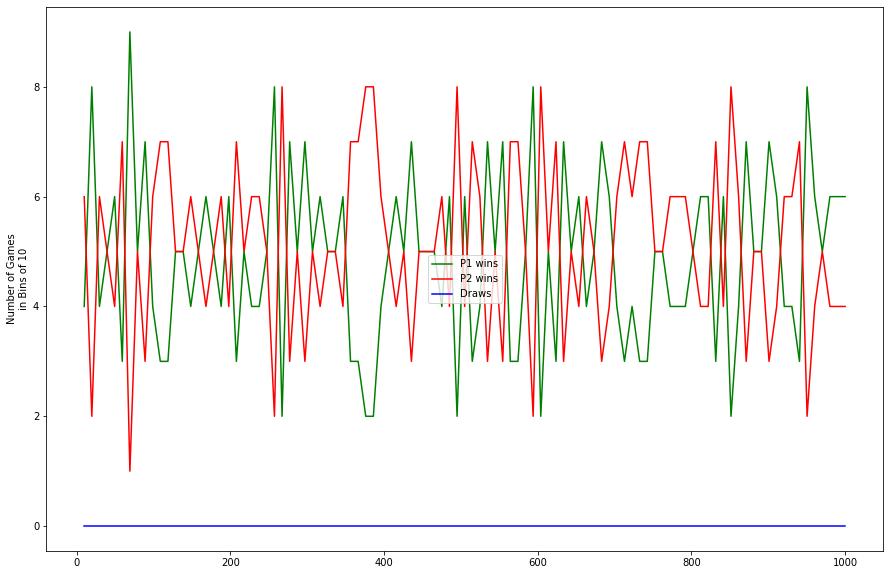

In [48]:
plot_outcomes(outcomes_2_SGD_TanH, 1000, 1000)

54.14426067359607 0.004142875509185852 123.45679012345678
40.64114204998538 0.9847536458637353 123.45679012345678


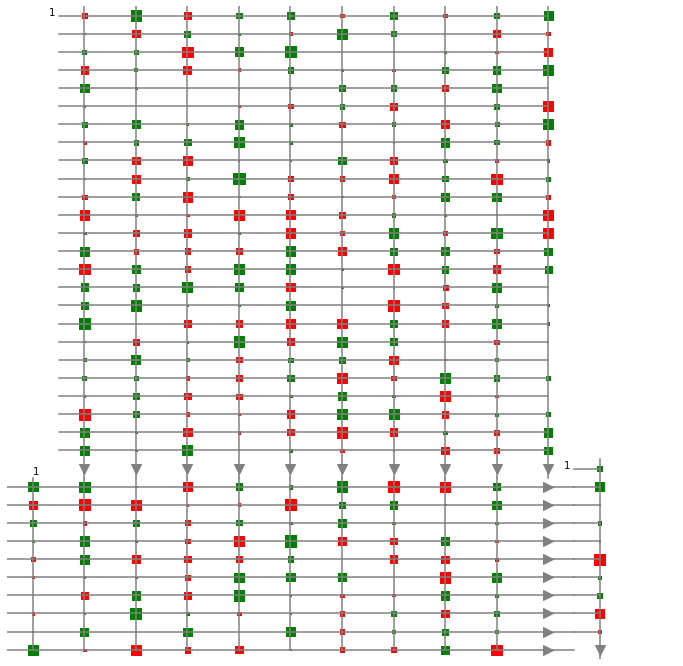

In [49]:
draw_Qnet(Qnet_2_SGD_TanH)

#### SGD, ReLU

In [50]:
Qnet_2_SGD_ReLU, outcomes_2_SGD_ReLU, samples_2_SGD_ReLU = train_Qnet(n_batches, n_reps_per_batch, network,
                                                                         n_iterations, learning_rate, epsilon,
                                                                         epsilon_decay_factor, valid_moves,
                                                                         make_move, box_created, relu=True, use_SGD=True)

DONE


In [51]:
start_state = [0]*24
Q_2s_SGD_ReLU = [Qnet_2_SGD_ReLU.use_pytorch(tensor(np.array(start_state + [m]))) for m in range(24)]
print_prediction(Q_2s_SGD_ReLU)

    •    [-0.01725724]    •    [-0.02310983]    •    [-0.02050811]    •    
[0.00215118]      [0.00408678]      [0.00356272]      [0.00261881]
    •    [-0.01991559]    •    [-0.01903748]    •    [-0.01815937]    •    
[0.0016749]      [0.00073099]      [-0.00021292]      [-0.00115683]
    •    [-0.01593323]    •    [-0.01160892]    •    [-0.0072846]    •    
[-0.00210074]      [-0.00304465]      [-0.00398856]      [-0.00493247]
    •    [-0.00365561]    •    [-0.00172001]    •    [0.00021559]    •    


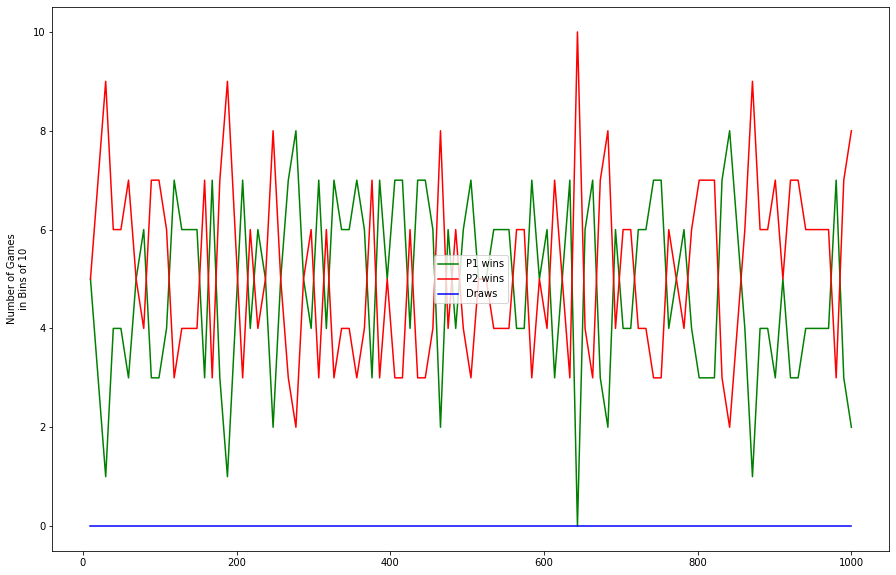

In [52]:
plot_outcomes(outcomes_2_SGD_ReLU, 1000, 1000)

55.346549653167806 0.0014275946546714027 123.45679012345678
39.849350875131016 1.7076021965420083 123.45679012345678


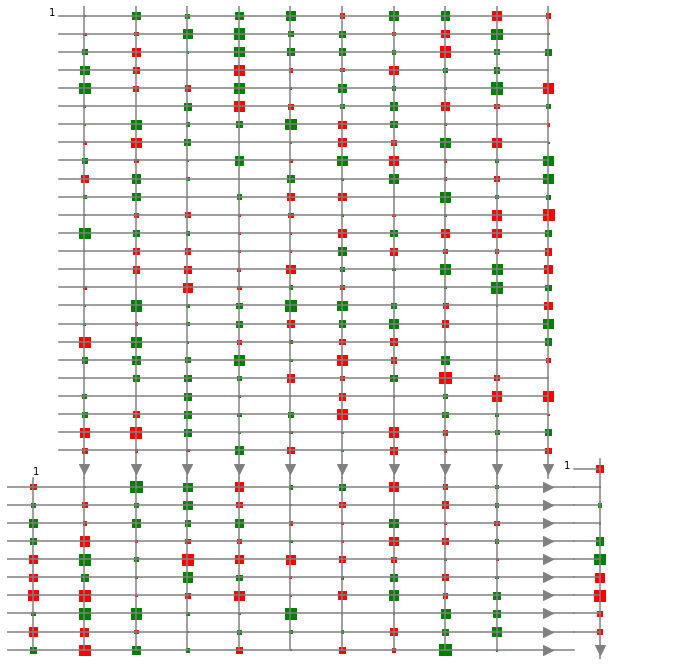

In [53]:
draw_Qnet(Qnet_2_SGD_ReLU)

### Parameter values \#3

In [54]:
n_batches = 100
n_reps_per_batch = 1000
n_iterations = 250
network = [20, 20, 20]
learning_rate = 0.0025
epsilon = 1
epsilon_decay_factor = 0.92

#### Adam, TanH

In [55]:
Qnet_3_Adam_TanH, outcomes_3_Adam_TanH, samples_3_Adam_TanH = train_Qnet(n_batches, n_reps_per_batch, network,
                                                                         n_iterations, learning_rate, epsilon,
                                                                         epsilon_decay_factor, valid_moves,
                                                                         make_move, box_created)

DONE


In [56]:
start_state = [0]*24
Q_3s_Adam_TanH = [Qnet_3_Adam_TanH.use_pytorch(tensor(np.array(start_state + [m]))) for m in range(24)]
print_prediction(Q_3s_Adam_TanH)

    •    [0.30433556]    •    [0.28680612]    •    [0.26491026]    •    
[0.06268082]      [0.04924639]      [0.03884801]      [0.0308826]
    •    [0.24558765]    •    [0.22847302]    •    [0.21080601]    •    
[0.02476342]      [0.0199975]      [0.01619831]      [0.01307142]
    •    [0.1913738]    •    [0.1699611]    •    [0.14675165]    •    
[0.01039365]      [0.00799415]      [0.00573963]      [0.00352367]
    •    [0.12281687]    •    [0.09990154]    •    [0.07958195]    •    


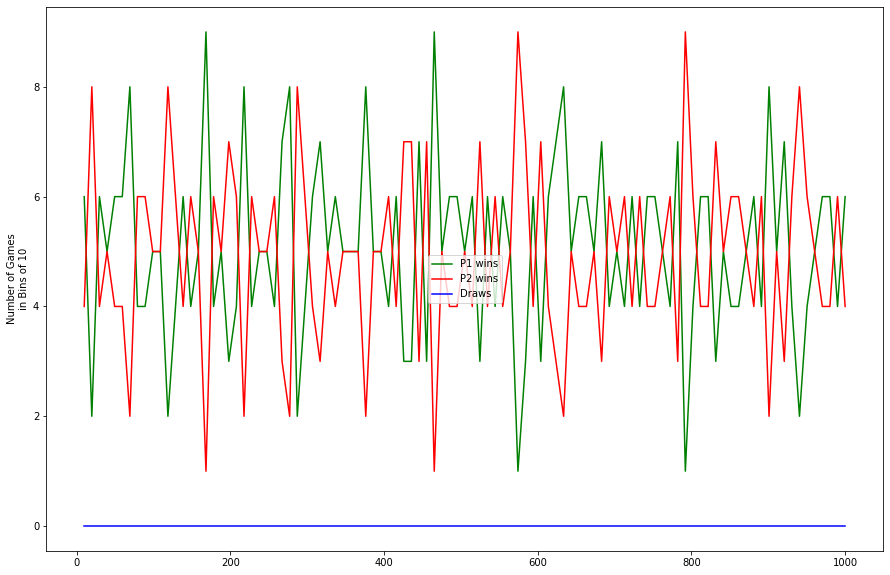

In [57]:
plot_outcomes(outcomes_3_Adam_TanH, 1000, 1000)

1.6899975224965804 8.424765237833772e-08 39.0625
1.8234546742500308 1.0095337174762028e-06 39.0625


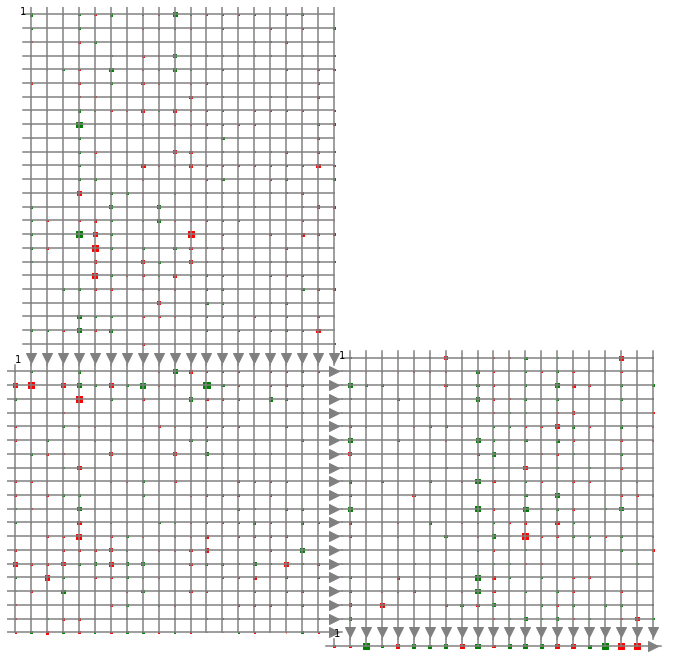

In [58]:
draw_Qnet(Qnet_3_Adam_TanH)

#### Adam, ReLU

In [59]:
Qnet_3_Adam_ReLU, outcomes_3_Adam_ReLU, samples_3_Adam_ReLU = train_Qnet(n_batches, n_reps_per_batch, network,
                                                                         n_iterations, learning_rate, epsilon,
                                                                         epsilon_decay_factor, valid_moves,
                                                                         make_move, box_created, relu=True)

DONE


In [60]:
start_state = [0]*24
Q_3s_Adam_ReLU = [Qnet_3_Adam_ReLU.use_pytorch(tensor(np.array(start_state + [m]))) for m in range(24)]
print_prediction(Q_3s_Adam_ReLU)

    •    [0.20502423]    •    [-0.15318532]    •    [-0.09930382]    •    
[0.13212823]      [0.17252132]      [0.21291441]      [0.2533075]
    •    [-0.07688252]    •    [-0.13647733]    •    [-0.18259018]    •    
[0.29370058]      [0.33409367]      [0.37448676]      [0.41487984]
    •    [-0.11023029]    •    [-0.0698372]    •    [-0.02944411]    •    
[0.45527293]      [0.49566602]      [0.5360591]      [0.57645219]
    •    [0.01094897]    •    [0.05134206]    •    [0.09173515]    •    


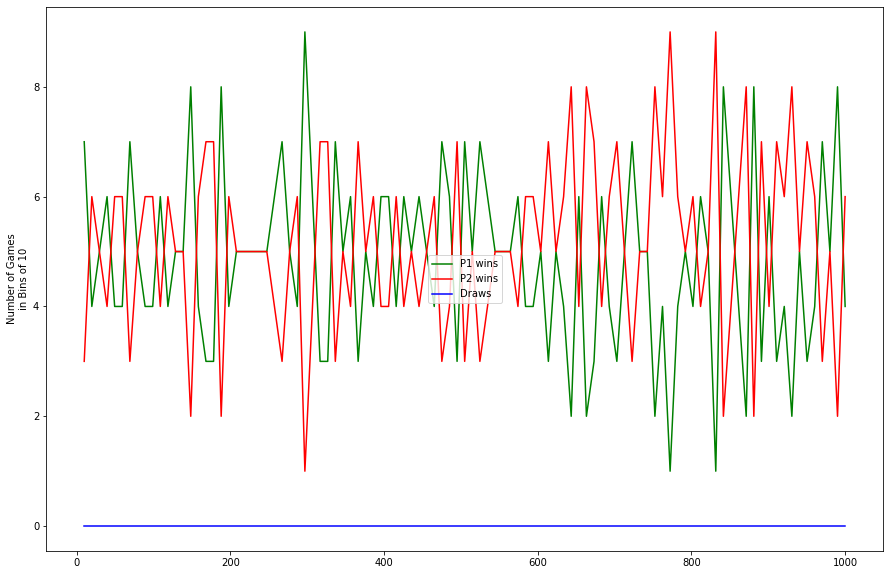

In [61]:
plot_outcomes(outcomes_3_Adam_ReLU, 1000, 1000)

2.8253036660447552 1.772338198207049e-05 39.0625
1.6717246989883723 1.027536903316405e-06 39.0625


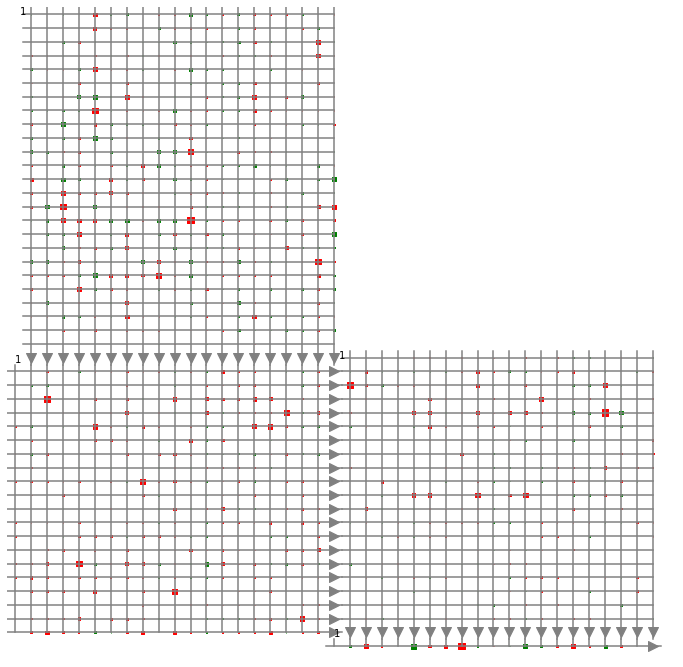

In [62]:
draw_Qnet(Qnet_3_Adam_ReLU)

#### SGD, TanH

In [63]:
Qnet_3_SGD_TanH, outcomes_3_SGD_TanH, samples_3_SGD_TanH = train_Qnet(n_batches, n_reps_per_batch, network,
                                                                         n_iterations, learning_rate, epsilon,
                                                                         epsilon_decay_factor, valid_moves,
                                                                         make_move, box_created, use_SGD=True)

DONE


In [64]:
start_state = [0]*24
Q_3s_SGD_TanH = [Qnet_3_SGD_TanH.use_pytorch(tensor(np.array(start_state + [m]))) for m in range(24)]
print_prediction(Q_3s_SGD_TanH)

    •    [0.07229253]    •    [0.07502036]    •    [0.077404]    •    
[0.09145414]      [0.09171962]      [0.09180001]      [0.09172309]
    •    [0.07951657]    •    [0.08146207]    •    [0.08330635]    •    
[0.09151533]      [0.09120063]      [0.09079983]      [0.09033062]
    •    [0.08505463]    •    [0.0866692]    •    [0.08809959]    •    
[0.08980768]      [0.08924308]      [0.08864654]      [0.08802586]
    •    [0.08930516]    •    [0.09026475]    •    [0.09097667]    •    


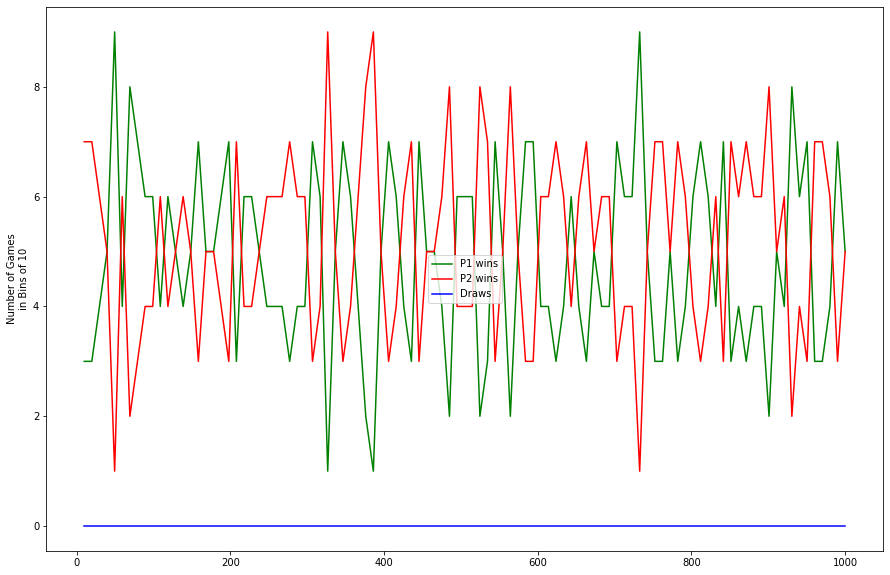

In [65]:
plot_outcomes(outcomes_3_SGD_TanH, 1000, 1000)

28.86930436443753 3.1133210679313955e-06 39.0625
26.29695985074565 0.0012643359358222375 39.0625


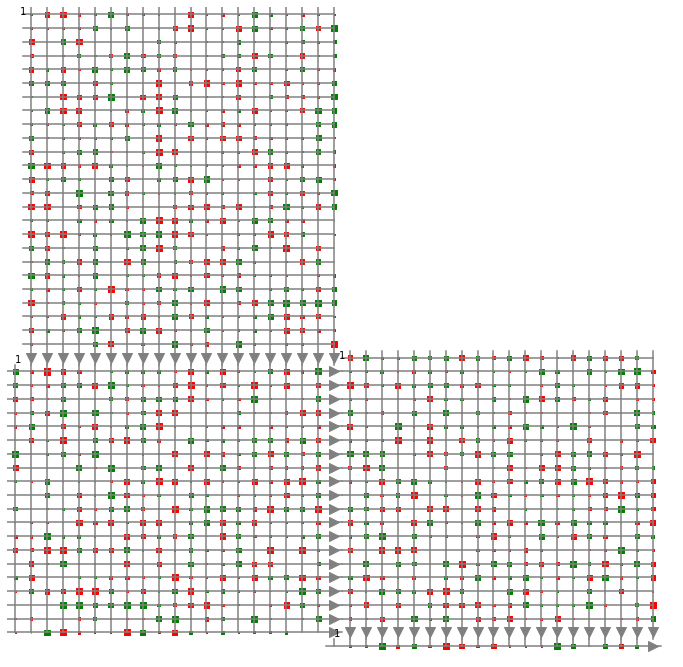

In [66]:
draw_Qnet(Qnet_3_SGD_TanH)

#### SGD, ReLU

In [67]:
Qnet_3_SGD_ReLU, outcomes_3_SGD_ReLU, samples_3_SGD_ReLU = train_Qnet(n_batches, n_reps_per_batch, network,
                                                                         n_iterations, learning_rate, epsilon,
                                                                         epsilon_decay_factor, valid_moves,
                                                                         make_move, box_created, relu=True, use_SGD=True)

DONE


In [68]:
start_state = [0]*24
Q_3s_SGD_ReLU = [Qnet_3_SGD_ReLU.use_pytorch(tensor(np.array(start_state + [m]))) for m in range(24)]
print_prediction(Q_3s_SGD_ReLU)

    •    [-0.42640198]    •    [-0.43204817]    •    [-0.44079302]    •    
[-0.45510748]      [-0.45445427]      [-0.45380933]      [-0.45316438]
    •    [-0.44872488]    •    [-0.45424176]    •    [-0.45622174]    •    
[-0.45239246]      [-0.45152602]      [-0.45065958]      [-0.44979315]
    •    [-0.45601436]    •    [-0.4579144]    •    [-0.4578205]    •    
[-0.44892671]      [-0.44806027]      [-0.44719383]      [-0.45128198]
    •    [-0.45711699]    •    [-0.45644715]    •    [-0.45577732]    •    


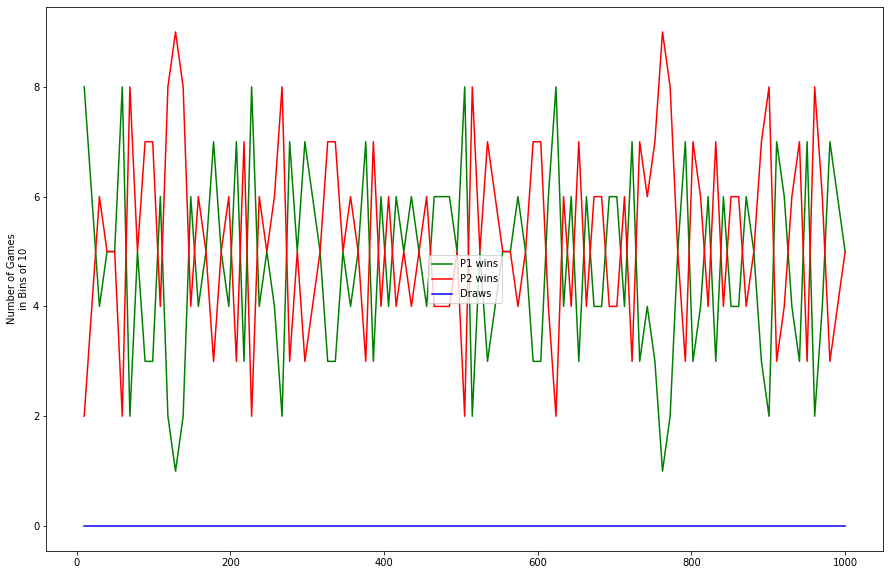

In [69]:
plot_outcomes(outcomes_3_SGD_ReLU, 1000, 1000)

29.54730227459729 0.0029391924128341434 39.0625
25.450863636589883 1.5603070007685635e-07 39.0625


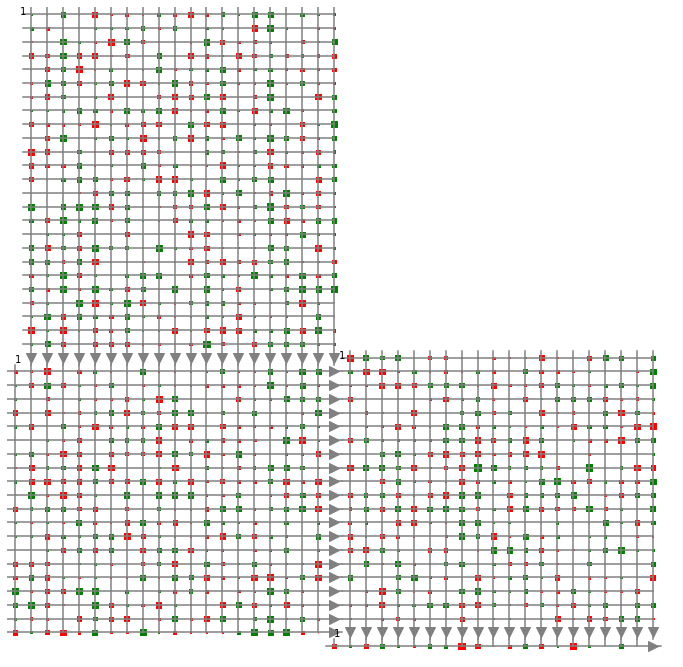

In [70]:
draw_Qnet(Qnet_3_SGD_ReLU)

### Parameter values \#4

In [71]:
n_batches = 250
n_reps_per_batch = 1000
n_iterations = 500
network = [50, 50, 50, 50]
learning_rate = 0.00125
epsilon = 1
epsilon_decay_factor = 0.9

#### Adam, TanH

In [72]:
Qnet_4_Adam_TanH, outcomes_4_Adam_TanH, samples_4_Adam_TanH = train_Qnet(n_batches, n_reps_per_batch, network,
                                                                         n_iterations, learning_rate, epsilon,
                                                                         epsilon_decay_factor, valid_moves,
                                                                         make_move, box_created)

DONE


In [73]:
start_state = [0]*24
Q_4s_Adam_TanH = [Qnet_4_Adam_TanH.use_pytorch(tensor(np.array(start_state + [m]))) for m in range(24)]
print_prediction(Q_4s_Adam_TanH)

    •    [0.06159919]    •    [-0.16030736]    •    [-0.40168726]    •    
[-0.4705334]      [-0.56002504]      [-0.59478568]      [-0.57171146]
    •    [-0.41446467]    •    [-0.577694]    •    [-0.79424038]    •    
[-0.53976263]      [-0.4916623]      [-0.39188621]      [-0.28619083]
    •    [-0.77586763]    •    [-0.69504654]    •    [-0.5515325]    •    
[-0.27787592]      [-0.39504118]      [-0.56964575]      [-0.76022387]
    •    [-0.43616051]    •    [-0.37730112]    •    [-0.39159347]    •    


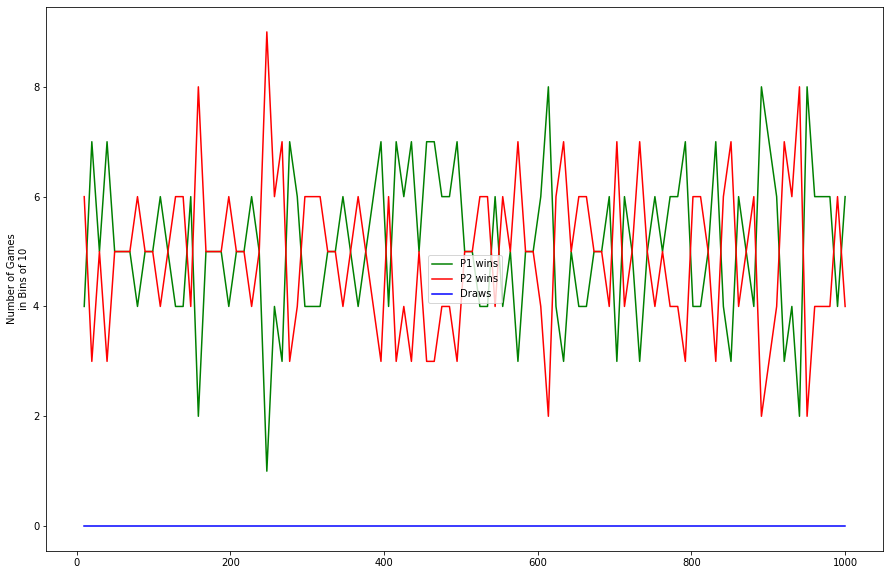

In [74]:
plot_outcomes(outcomes_4_Adam_TanH, 1000, 1000)

0.31232843787412895 1.22771775174758e-08 4.938271604938272
0.6652467177190433 2.427040228256527e-10 4.938271604938272
3.1829196768231056 0.02963783460146469 4.938271604938272


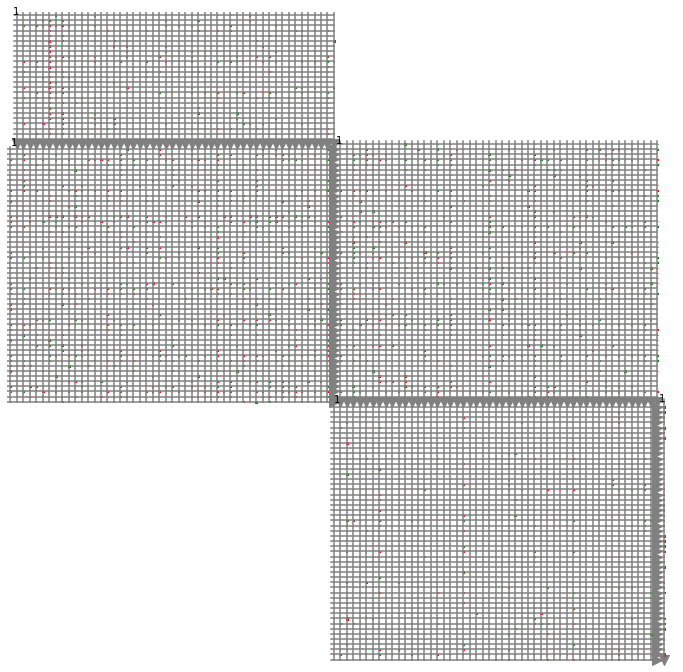

In [75]:
draw_Qnet(Qnet_4_Adam_TanH)

#### Adam, ReLU

In [ ]:
Qnet_4_Adam_ReLU, outcomes_4_Adam_ReLU, samples_4_Adam_ReLU = train_Qnet(n_batches, n_reps_per_batch, network,
                                                                         n_iterations, learning_rate, epsilon,
                                                                         epsilon_decay_factor, valid_moves,
                                                                         make_move, box_created, relu=True)

In [ ]:
start_state = [0]*24
Q_4s_Adam_ReLU = [Qnet_4_Adam_ReLU.use_pytorch(tensor(np.array(start_state + [m]))) for m in range(24)]
print_prediction(Q_4s_Adam_ReLU)

In [ ]:
plot_outcomes(outcomes_4_Adam_ReLU, 1000, 1000)

In [ ]:
draw_Qnet(Qnet_4_Adam_ReLU)

#### SGD, TanH

In [ ]:
Qnet_4_SGD_TanH, outcomes_4_SGD_TanH, samples_4_SGD_TanH = train_Qnet(n_batches, n_reps_per_batch, network,
                                                                         n_iterations, learning_rate, epsilon,
                                                                         epsilon_decay_factor, valid_moves,
                                                                         make_move, box_created, use_SGD=True)

In [ ]:
start_state = [0]*24
Q_4s_SGD_TanH = [Qnet_4_SGD_TanH.use_pytorch(tensor(np.array(start_state + [m]))) for m in range(24)]
print_prediction(Q_4s_SGD_TanH)

In [ ]:
plot_outcomes(outcomes_4_SGD_TanH, 1000, 1000)

In [ ]:
draw_Qnet(Qnet_4_SGD_TanH)

#### SGD, ReLU

In [ ]:
Qnet_4_SGD_ReLU, outcomes_4_SGD_ReLU, samples_4_SGD_ReLU = train_Qnet(n_batches, n_reps_per_batch, network,
                                                                         n_iterations, learning_rate, epsilon,
                                                                         epsilon_decay_factor, valid_moves,
                                                                         make_move, box_created, relu=True, use_SGD=True)

In [ ]:
start_state = [0]*24
Q_4s_SGD_ReLU = [Qnet_4_SGD_ReLU.use_pytorch(tensor(np.array(start_state + [m]))) for m in range(24)]
print_prediction(Q_4s_SGD_ReLU)

In [ ]:
plot_outcomes(outcomes_4_SGD_ReLU, 1000, 1000)

In [ ]:
draw_Qnet(Qnet_4_SGD_ReLU)

## Testing

Testing the predictions made by the trained models for a sample game state.

In [77]:
state = make_move(make_move(make_move(make_move(make_move(make_move([0]*24, 0), 3), 12), 13), 1), 4)
print_game(state)
moves = valid_moves(state)

•---•---•   •
|   |
•---•---•   •

•   •   •   •

•   •   •   •


### Neural Network 1

#### Adam, TanH

In [78]:
Qs = [Qnet_1_Adam_TanH.use_pytorch(torch.from_numpy(np.array(state + [m])).double()) for m in moves]
print('Best move for player 1 according to first neural network (using Adam optimizer and TanH activation function)')
print_game(make_move(state, moves[(np.argmax(np.array(Qs)))]))
print()
print('Best move for player 2 according to first neural network (using Adam optimizer and TanH activation function)')
print_game(make_move(state, moves[(np.argmin(np.array(Qs)))]))

Best move for player 1 according to first neural network (using Adam optimizer and TanH activation function)
•---•---•---•
|   |
•---•---•   •

•   •   •   •

•   •   •   •

Best move for player 2 according to first neural network (using Adam optimizer and TanH activation function)
•---•---•   •
|   |
•---•---•   •

•   •   •   •
            |
•   •   •   •


#### Adam, ReLU

In [79]:
Qs = [Qnet_1_Adam_ReLU.use_pytorch(torch.from_numpy(np.array(state + [m])).double()) for m in moves]
print('Best move for player 1 according to first neural network (using Adam optimizer and ReLU activation function)')
print_game(make_move(state, moves[(np.argmax(np.array(Qs)))]))
print()
print('Best move for player 2 according to first neural network (using Adam optimizer and ReLU activation function)')
print_game(make_move(state, moves[(np.argmin(np.array(Qs)))]))

Best move for player 1 according to first neural network (using Adam optimizer and ReLU activation function)
•---•---•   •
|   |
•---•---•   •

•   •   •   •
            |
•   •   •   •

Best move for player 2 according to first neural network (using Adam optimizer and ReLU activation function)
•---•---•---•
|   |
•---•---•   •

•   •   •   •

•   •   •   •


#### SGD, TanH

In [80]:
Qs = [Qnet_1_SGD_TanH.use_pytorch(torch.from_numpy(np.array(state + [m])).double()) for m in moves]
print('Best move for player 1 according to first neural network (using SGD optimizer and TanH activation function)')
print_game(make_move(state, moves[(np.argmax(np.array(Qs)))]))
print()
print('Best move for player 2 according to first neural network (using SGD optimizer and TanH activation function)')
print_game(make_move(state, moves[(np.argmin(np.array(Qs)))]))

Best move for player 1 according to first neural network (using SGD optimizer and TanH activation function)
•---•---•   •
|   |
•---•---•   •

•   •   •   •
            |
•   •   •   •

Best move for player 2 according to first neural network (using SGD optimizer and TanH activation function)
•---•---•---•
|   |
•---•---•   •

•   •   •   •

•   •   •   •


#### SGD, ReLU

In [81]:
Qs = [Qnet_1_SGD_ReLU.use_pytorch(torch.from_numpy(np.array(state + [m])).double()) for m in moves]
print('Best move for player 1 according to first neural network (using SGD optimizer and ReLU activation function)')
print_game(make_move(state, moves[(np.argmax(np.array(Qs)))]))
print()
print('Best move for player 2 according to first neural network (using SGD optimizer and ReLU activation function)')
print_game(make_move(state, moves[(np.argmin(np.array(Qs)))]))

Best move for player 1 according to first neural network (using SGD optimizer and ReLU activation function)
•---•---•   •
|   |
•---•---•   •

•   •   •   •
            |
•   •   •   •

Best move for player 2 according to first neural network (using SGD optimizer and ReLU activation function)
•---•---•---•
|   |
•---•---•   •

•   •   •   •

•   •   •   •


### Neural Network 2

#### Adam, TanH

In [82]:
Qs = [Qnet_2_Adam_TanH.use_pytorch(torch.from_numpy(np.array(state + [m])).double()) for m in moves]
print('Best move for player 1 according to second neural network (using Adam optimizer and TanH activation function)')
print_game(make_move(state, moves[(np.argmax(np.array(Qs)))]))
print()
print('Best move for player 2 according to second neural network (using Adam optimizer and TanH activation function)')
print_game(make_move(state, moves[(np.argmin(np.array(Qs)))]))

Best move for player 1 according to second neural network (using Adam optimizer and TanH activation function)
•---•---•---•
|   |
•---•---•   •

•   •   •   •

•   •   •   •

Best move for player 2 according to second neural network (using Adam optimizer and TanH activation function)
•---•---•   •
|   |
•---•---•---•

•   •   •   •

•   •   •   •


#### Adam, ReLU

In [83]:
Qs = [Qnet_2_Adam_ReLU.use_pytorch(torch.from_numpy(np.array(state + [m])).double()) for m in moves]
print('Best move for player 1 according to second neural network (using Adam optimizer and ReLU activation function)')
print_game(make_move(state, moves[(np.argmax(np.array(Qs)))]))
print()
print('Best move for player 2 according to second neural network (using Adam optimizer and ReLU activation function)')
print_game(make_move(state, moves[(np.argmin(np.array(Qs)))]))

Best move for player 1 according to second neural network (using Adam optimizer and ReLU activation function)
•---•---•   •
|   |
•---•---•   •

•---•   •   •

•   •   •   •

Best move for player 2 according to second neural network (using Adam optimizer and ReLU activation function)
•---•---•---•
|   |
•---•---•   •

•   •   •   •

•   •   •   •


#### SGD, TanH

In [84]:
Qs = [Qnet_2_SGD_TanH.use_pytorch(torch.from_numpy(np.array(state + [m])).double()) for m in moves]
print('Best move for player 1 according to second neural network (using SGD optimizer and TanH activation function)')
print_game(make_move(state, moves[(np.argmax(np.array(Qs)))]))
print()
print('Best move for player 2 according to second neural network (using SGD optimizer and TanH activation function)')
print_game(make_move(state, moves[(np.argmin(np.array(Qs)))]))

Best move for player 1 according to second neural network (using SGD optimizer and TanH activation function)
•---•---•   •
|   |
•---•---•   •

•   •   •   •
            |
•   •   •   •

Best move for player 2 according to second neural network (using SGD optimizer and TanH activation function)
•---•---•---•
|   |
•---•---•   •

•   •   •   •

•   •   •   •


#### SGD, ReLU

In [85]:
Qs = [Qnet_2_SGD_ReLU.use_pytorch(torch.from_numpy(np.array(state + [m])).double()) for m in moves]
print('Best move for player 1 according to second neural network (using SGD optimizer and ReLU activation function)')
print_game(make_move(state, moves[(np.argmax(np.array(Qs)))]))
print()
print('Best move for player 2 according to second neural network (using SGD optimizer and ReLU activation function)')
print_game(make_move(state, moves[(np.argmin(np.array(Qs)))]))

Best move for player 1 according to second neural network (using SGD optimizer and ReLU activation function)
•---•---•   •
|   |
•---•---•   •

•   •   •   •

•   •   •---•

Best move for player 2 according to second neural network (using SGD optimizer and ReLU activation function)
•---•---•---•
|   |
•---•---•   •

•   •   •   •

•   •   •   •


### Neural Network 3

#### Adam, TanH

In [86]:
Qs = [Qnet_3_Adam_TanH.use_pytorch(torch.from_numpy(np.array(state + [m])).double()) for m in moves]
print('Best move for player 1 according to third neural network (using Adam optimizer and TanH activation function)')
print_game(make_move(state, moves[(np.argmax(np.array(Qs)))]))
print()
print('Best move for player 2 according to third neural network (using Adam optimizer and TanH activation function)')
print_game(make_move(state, moves[(np.argmin(np.array(Qs)))]))

Best move for player 1 according to third neural network (using Adam optimizer and TanH activation function)
•---•---•---•
|   |
•---•---•   •

•   •   •   •

•   •   •   •

Best move for player 2 according to third neural network (using Adam optimizer and TanH activation function)
•---•---•   •
|   |
•---•---•   •

•   •   •   •
|
•   •   •   •


#### Adam, ReLU

In [87]:
Qs = [Qnet_3_Adam_ReLU.use_pytorch(torch.from_numpy(np.array(state + [m])).double()) for m in moves]
print('Best move for player 1 according to third neural network (using Adam optimizer and ReLU activation function)')
print_game(make_move(state, moves[(np.argmax(np.array(Qs)))]))
print()
print('Best move for player 2 according to third neural network (using Adam optimizer and ReLU activation function)')
print_game(make_move(state, moves[(np.argmin(np.array(Qs)))]))

Best move for player 1 according to third neural network (using Adam optimizer and ReLU activation function)
•---•---•   •
|   |
•---•---•   •

•   •   •   •

•---•   •   •

Best move for player 2 according to third neural network (using Adam optimizer and ReLU activation function)
•---•---•   •
|   |
•---•---•   •

•   •   •   •
            |
•   •   •   •


#### SGD, TanH

In [88]:
Qs = [Qnet_3_SGD_TanH.use_pytorch(torch.from_numpy(np.array(state + [m])).double()) for m in moves]
print('Best move for player 1 according to third neural network (using SGD optimizer and TanH activation function)')
print_game(make_move(state, moves[(np.argmax(np.array(Qs)))]))
print()
print('Best move for player 2 according to third neural network (using SGD optimizer and TanH activation function)')
print_game(make_move(state, moves[(np.argmin(np.array(Qs)))]))

Best move for player 1 according to third neural network (using SGD optimizer and TanH activation function)
•---•---•   •
|   |
•---•---•   •

•   •   •   •
            |
•   •   •   •

Best move for player 2 according to third neural network (using SGD optimizer and TanH activation function)
•---•---•---•
|   |
•---•---•   •

•   •   •   •

•   •   •   •


#### SGD, ReLU

In [89]:
Qs = [Qnet_3_SGD_ReLU.use_pytorch(torch.from_numpy(np.array(state + [m])).double()) for m in moves]
print('Best move for player 1 according to third neural network (using SGD optimizer and ReLU activation function)')
print_game(make_move(state, moves[(np.argmax(np.array(Qs)))]))
print()
print('Best move for player 2 according to third neural network (using SGD optimizer and ReLU activation function)')
print_game(make_move(state, moves[(np.argmin(np.array(Qs)))]))

Best move for player 1 according to third neural network (using SGD optimizer and ReLU activation function)
•---•---•---•
|   |
•---•---•   •

•   •   •   •

•   •   •   •

Best move for player 2 according to third neural network (using SGD optimizer and ReLU activation function)
•---•---•   •
|   |
•---•---•   •

•   •   •   •

•---•   •   •


### Neural Network 4

#### Adam, TanH

In [ ]:
Qs = [Qnet_4_Adam_TanH.use_pytorch(torch.from_numpy(np.array(state + [m])).double()) for m in moves]
print('Best move for player 1 according to third neural network (using Adam optimizer and TanH activation function)')
print_game(make_move(state, moves[(np.argmax(np.array(Qs)))]))
print()
print('Best move for player 2 according to third neural network (using Adam optimizer and TanH activation function)')
print_game(make_move(state, moves[(np.argmin(np.array(Qs)))]))

#### Adam, ReLU

In [ ]:
Qs = [Qnet_4_Adam_ReLU.use_pytorch(torch.from_numpy(np.array(state + [m])).double()) for m in moves]
print('Best move for player 1 according to third neural network (using Adam optimizer and ReLU activation function)')
print_game(make_move(state, moves[(np.argmax(np.array(Qs)))]))
print()
print('Best move for player 2 according to third neural network (using Adam optimizer and ReLU activation function)')
print_game(make_move(state, moves[(np.argmin(np.array(Qs)))]))

#### SGD, TanH

In [ ]:
Qs = [Qnet_4_SGD_TanH.use_pytorch(torch.from_numpy(np.array(state + [m])).double()) for m in moves]
print('Best move for player 1 according to third neural network (using SGD optimizer and TanH activation function)')
print_game(make_move(state, moves[(np.argmax(np.array(Qs)))]))
print()
print('Best move for player 2 according to third neural network (using SGD optimizer and TanH activation function)')
print_game(make_move(state, moves[(np.argmin(np.array(Qs)))]))

#### SGD, ReLU

In [ ]:
Qs = [Qnet_4_SGD_ReLU.use_pytorch(torch.from_numpy(np.array(state + [m])).double()) for m in moves]
print('Best move for player 1 according to third neural network (using SGD optimizer and ReLU activation function)')
print_game(make_move(state, moves[(np.argmax(np.array(Qs)))]))
print()
print('Best move for player 2 according to third neural network (using SGD optimizer and ReLU activation function)')
print_game(make_move(state, moves[(np.argmin(np.array(Qs)))]))

## Observations

* The values returned by the neural network are extremely sparse. This is likely because:
    * The reinforcements during the training are extremely sparse, with the only reinforcements other than 0 being 1 and -1, and those too only when the game terminates. Hence, all the intermediate steps have extremely low values.
    * The fluctuations in wins and losses might reduce the overall reinforcement value for a particular move.
* The number of wins and losses for each player fluctuates consistently, not skewing in favor of either player. This is likely because both players are playing optimally, and are hence learning at the same pace with each outcome. The overall performance between the two is balanced likely because each player continuously devises a strategy to win against the other, resulting in the tables turning repeatedly.
* When trying to observe the move taken for a particular state, the seemingly best local greedy move might not be the optimal move overall; this is because the game of dots & boxes is determined by the end score instead of an intermediate goal. Hence, it is hard to analyze whether or not the move taken is globally optimal or incorrectly learned.

## Results

The values for each edge/available move at the starting state are displayed. Higher values denote moves which have a higher likelihood of player 1 winning, and vice versa.

The outcomes for the games are also collected and plotted to determine the performance of the program over time. Unlike the expected outcome of a reinforcement learning program, where the number of wins gradually continues to improve with experience, in this scenario, the number of wins and losses is fairly evenly balanced due to both players playing optimally.

Finally, the Qnets are explored to determine which is the most optimal move for a random state. In certain cases, the seemingly obvious move is not chosen, likely due to past experience indicating that while it might _seem_ like a good move, it resulted in a loss overall.

## References

1. Berlekamp, Elwyn R.; Conway, John H.; Guy, Richard K. (1982), "Chapter 16: Dots-and-Boxes", _Winning Ways for your Mathematical Plays, Volume 2: Games in Particular_, Academic Press, pp. 507–550.